`Grabplot` is a small utilitary tool for plotting simple shapes on the integer lattices using a Matplotlib backend. The resulting figure can be saved as a `.poly` file and fed to Triangulation softwares such as [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).


![demo](intro.png)


The interactive `matplotlib` figure has the following functionalities:
  * Clicking anywhere on the figure adds a point to the current contour and maps it to the closest point in the integer lattice.
  * Pressing `s` saves the current graph.
  * Pressing `x` removes the latest point from the graph.
  * pressing `h` joins the current contour and starts a new polygon (filled).
  * Pressing `n` joins the current contour and starts a new polygon (hole).
  * Pressing `Enter` saves the .poly file, closes the figure and displays the result.

In [7]:
import os
import sys
import time
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
pt_color = "#f1595f"
fill_color = "#7bbcf5"
hole_color = "#dddddd"
line_color = "#599ad3"

We first define an interactive line tracker object that keeps track of the keyboard events and point clicks on the figure. It also matches each click point the closest point on the integer lattice if the click event is close enough (see `accept_thresh` parameter). 

We then write an I/O function to output the given shape as a `.poly` file. A `.poly` file defines the vertices of the shape (newline separated), then the filled contours of the shape (as a list of points) and finally the holes in the shape , again as a list of point. In particular, this file format can be used as input format for [Triangle](https://www.cs.cmu.edu/~quake/triangle.html) software for meshing or Triangulation.

In [8]:
class LineTracker:
    def __init__(self, fig, output_file=None, accept_thresh=0.5):
        """Initializes the LineTracker object taking care of saving the coordinates 
        and displaying the selected points.
        """
        self.lines = []                    # Matplotlib lines objects
        self.coords = [[[], [], False]]    # (x, y, hole)
        self.accept_thresh = accept_thresh # How far a click can be from a point of the lattice
        self.fig = fig
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self)
        self.cid2 = self.fig.canvas.mpl_connect('key_press_event', self.press_handler)
        self.output_file = output_file

    def accept_point(self, x, y):
        """ Verify the click event belongs to the plotting grid and round it to the nearest point.

        Args:
         * ``x`` (*int*): x-coordinate.
         * ``y`` (*int*): y-coordinate.

        Returns:
         * ``accept`` (*bool*): True iff (x, y) lies close enough to one of the points on the grid.
        """
        return (abs(x - round(x)) < self.accept_thresh) and (abs(y - round(y)) < self.accept_thresh)

    def __call__(self, event):
        """Mouse click event routine."""
        ## Add a point to the graph
        if not(len(self.coords)):
            print >> sys.stderr, "No contours initialized. Press 'n' or 'h' to create a new one."
            return
        x, y = event.xdata, event.ydata
        if (not event.inaxes in self.fig.axes) or (not self.accept_point(x, y)):
            return
        x, y = round(x), round(y)
        self.coords[-1][0].append(x)
        self.coords[-1][1].append(y)
        ## If starting point of the current line
        if len(self.coords[-1][0]) == 1:
            self.lines.append(plt.plot([x], [y], color=line_color, mfc=pt_color, marker='o', 
                                       linewidth=2, linestyle='--' if self.coords[-1][2] else '-')[0])
        # Otherwise
        else:
            self.lines[-1].set_data(self.coords[-1][0], self.coords[-1][1])
        self.fig.canvas.draw()

    def press_handler(self, event):
        """Press key event routine."""
        ## Remove a point from the graph
        if event.key == 'x':
            if not len(self.coords):
                print >> sys.stderr, "No contours initialized. Press 'n' or 'h' to create a new one."
                return
            if len(self.coords[-1][0]) > 0:
                self.coords[-1][0] = self.coords[-1][0][:-1]
                self.coords[-1][1] = self.coords[-1][1][:-1]
                # Remove last line
                if not len(self.coords[-1][0]):
                    self.coords = self.coords[:-1]
                    if len(self.lines):
                        self.lines[-1].remove()
                    self.lines = self.lines[:-1]
                # Remove last point
                else:
                    self.lines[-1].set_data(self.coords[-1][0], self.coords[-1][1])
                self.fig.canvas.draw()
        ## Save the current graph in a .poly file
        elif event.key == 's':
            self.output_poly()
        ## Add a new line (hole or hull)
        elif event.key == 'h' or event.key == 'n' or event.key == 'enter':
            # Close previous line
            if len(self.coords) and (self.coords[-1][0][-1], 
                                     self.coords[-1][1][-1]) != (self.coords[-1][0][0], 
                                                                 self.coords[-1][1][0]):
                self.coords[-1][0].append(self.coords[-1][0][0])
                self.coords[-1][1].append(self.coords[-1][1][0])
                self.lines[-1].set_data(self.coords[-1][0], self.coords[-1][1])
                self.fig.canvas.draw()
            # Add new line
            if event.key == 'h' or event.key == 'n':
                self.coords.append([[], [], True if event.key == 'h' else False])
            # or finish
            else:
                self.output_poly()
                #fig.close()
                fig.clf()
                self.display()
            
    def display(self):
        """Displays a final view of the shape."""
        ax = fig.gca()
        patches = []
        for xs, ys, hole in self.coords:
            if not len(xs):
                continue
            polygon = Polygon(list(zip(xs, ys)), 
                              fc=hole_color if hole else fill_color,
                              zorder=bool(hole))
            ax.add_patch(polygon)
            ax.plot(xs, ys, color=line_color, marker='o', markerfacecolor=pt_color)
        ax.set_title('Final shape')
        ax.set_axis_off()
            
    def output_poly(self):
        """
        Output a .poly file describing the shape parsed from the plot.
        """
        if self.output_file is None:
            return
        # Hull coordinates
        point_indices = {}
        title = sys.argv[2] if len(sys.argv) > 2 else "shape"
        with open(self.output_file, "w") as f:
            # Parse each line
            pts, segs, holes = [], [], []
            for xs, ys, hole in self.coords:
                if not len(xs):
                    continue
                # Point coordinates
                ind_start = len(point_indices)
                for x, y in zip(xs, ys):
                    try:
                        point_indices[(x, y)]
                    except KeyError:
                        pts.append("%d %s %s" % (len(point_indices), x, y))
                        point_indices[(x, y)] = True
                # Segments
                ind_end = len(point_indices)
                segs.extend(["%d %d %d" % (p, p, p + 1 if p < ind_end - 1 else ind_start) 
                             for p in range(ind_start, ind_end)])
                # Holes
                if hole:
                    holes.append("%d %s %s" % (len(holes) + 1, float(sum(xs)) / 
                                               len(xs), float(sum(ys)) / len(ys)))
            if len(point_indices) < 3:
                print >> sys.stderr, "Error: vertices must be at least 3"
                raise SystemExit
            # Write
            f.write("%d 2 0 0\n" % len(point_indices))
            f.write("\n".join(pts))
            f.write("\n%s 0\n" % len(segs))
            f.write("\n".join(segs))
            f.write("\n%d\n" % len(holes))
            f.write("\n".join(holes))
            self.fig.suptitle('Saved' + time.strftime('%l:%M%p') )

Here is a minimal working example with an additional background image that can be used to trace a drawing for instance.

<IPython.core.display.Javascript object>


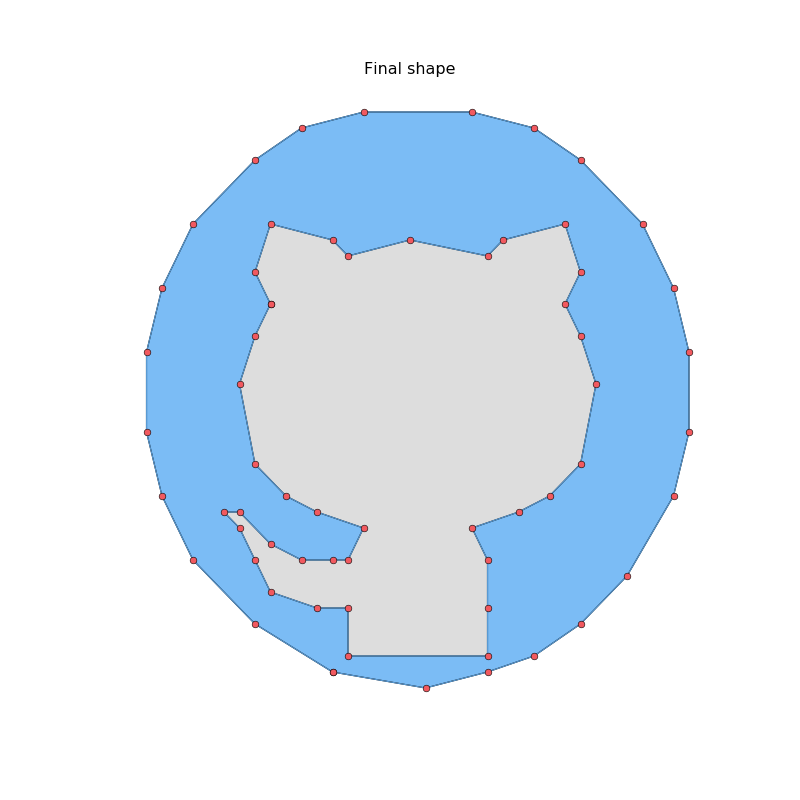

In [14]:
%matplotlib notebook
# Hyperparameters
title = "demo"
window_size = 40
background = "image.png"
output_file = "%s.poly" % title
# Create figure
fig = plt.figure(num='Grabplot - %s' % title, figsize=(10, 10))
ax = fig.add_subplot(111)
# Set window size and grid
ax.set_xticks(range(0, window_size, 1))
ax.set_yticks(range(0, window_size, 1))
plt.xlim([0, window_size])
plt.ylim([0, window_size])
if background is not None:    
    from scipy.misc import imread
    plt.imshow(imread(background), zorder=0, extent=[0., window_size, 0, window_size])
plt.grid()
# Start plotting
graph = LineTracker(fig, output_file=output_file)
plt.show()

Finally applying `triangle` on the output `.poly` file yields the following:


    triangle/triangle -p -g -q25 -a1 demo
    triangle/showme demo.1
    
![triangle](output_plot.png)